# 1. Credit Risk Modelling 

In this notebook , the credit risk dataset consisting of 32851 loan records to determine the best way to predict whether a loan applicant will fully repay or default on a loan. Here differnt machine learning models are tried
1. Random Forest
2. Catboost



As tthe dataset is unbalnced , these classifiers are tried after applying 
SMOTE, 
BorderLine SMOTE &
Oversmbling using Adaptive Synthetic Sampling (ADASYN). 

Out of all these variations Catboost with out SMOTE showed higher recall of all and random forest showed a stable performance with and with out smote. 

SO these two classifiers are selected as the final models for experimentaion.

 


## 1.1 Importing Libraries and loading the Dataset

In [1]:
#Importing LIbraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pylab as py

from sklearn.impute import SimpleImputer

 
import optuna
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
 
from sklearn.preprocessing import RobustScaler, PowerTransformer 

from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import  OneHotEncoder

from sklearn.model_selection import KFold, cross_val_score , train_test_split

from sklearn.ensemble import RandomForestClassifier,StackingClassifier
 
from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Oversample imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
 
from imblearn.over_sampling import BorderlineSMOTE, SMOTE,ADASYN

from matplotlib import pyplot
from numpy import where

import pickle

import warnings
warnings.filterwarnings('ignore')

/home/yael/anaconda3/envs/risk/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Function to Load data
def load_data(filename):
    df = pd.read_csv(filename)
    return df

In [27]:
#loading the dataset
df = load_data('../Data/credit_risk_dataset.csv')
df_copy = df.copy(deep=True)

# 2. Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


Out of total 32851 rows 'loan_int_rate' and 'person_emp_length' contains missing values.

There are 3 float variables, 5 integer variables and 4 object valriables there

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


In [6]:
df.describe(include='object')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,32581,32581,32581,32581
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,16446,6453,10777,26836


The number of catogeries in the four catogerical variables are not much high.
So can encode using one-hot encoding. 

Maximum people are taking loan for education. 

# 2.1 Checking Missing Vlaues are present or not

In [7]:
#Checking the number of missing values in each column
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [8]:
#percentage of null values in person_emp_length and loan_int_rate
(df.isnull().sum()/len(df))*100

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             2.747000
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 9.563856
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

Percantage of missing values in both the columns are under 30.

so can be treated with appropriate technique, after exploring the distribution etc 

# 2.2 Checking the  data distribution

In [9]:
#Function to display the distribution plot
def dist_plot(data,col):
     plt.figure()              
     sns.distplot(data[col].dropna())   
    

(None, None)

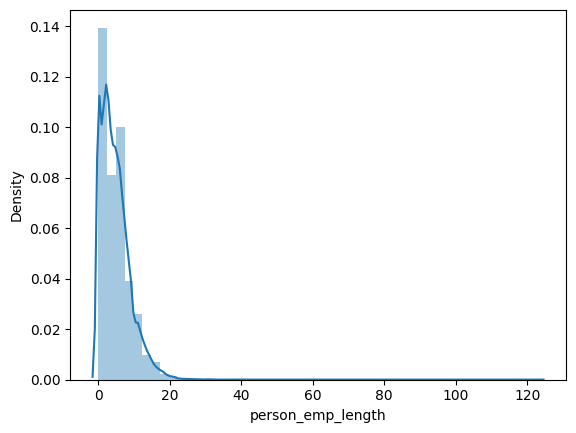

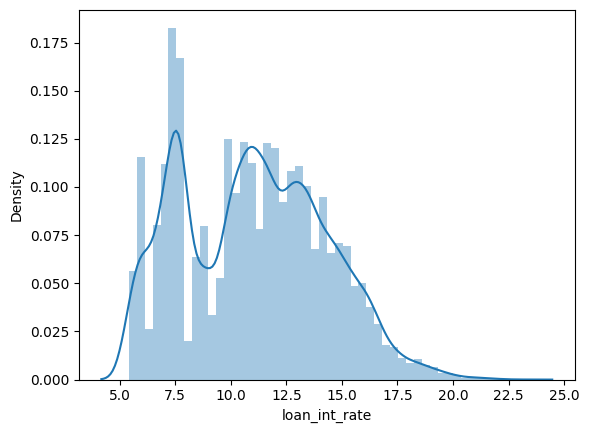

In [10]:
dist_plot(df,'person_emp_length'), dist_plot(df,'loan_int_rate')

Both are not following  a normal distribution. So preferably use 'median' to replace the missing values

Lets verify ith QQ plot

In [11]:
def qq_plot(data, col):
    sm.qqplot(data[col].dropna(), line ='45')
    py.show()

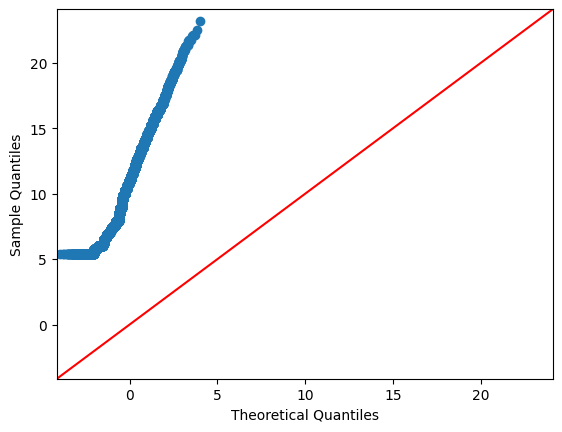

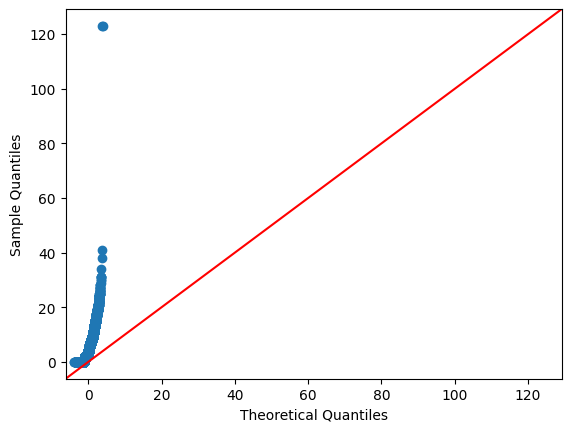

(None, None)

In [12]:
qq_plot(df, 'loan_int_rate'), qq_plot(df,'person_emp_length')

### Class distribution

In [13]:
#checking the percentage of each class
(df['loan_status'].value_counts()/len(df))*100

loan_status
0    78.183604
1    21.816396
Name: count, dtype: float64

Class imbalnce is there. Can deal with this issue later

### DIstribution of data of each feature

<Figure size 640x480 with 0 Axes>

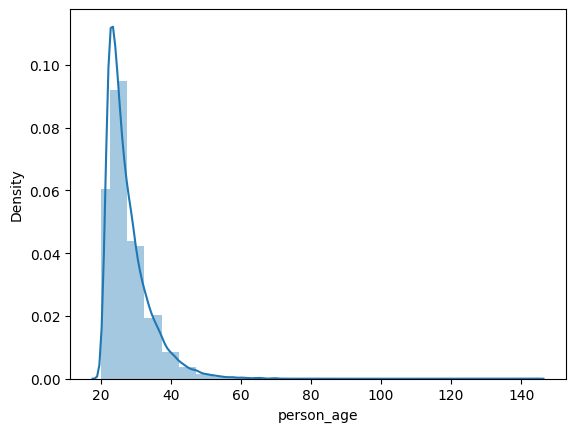

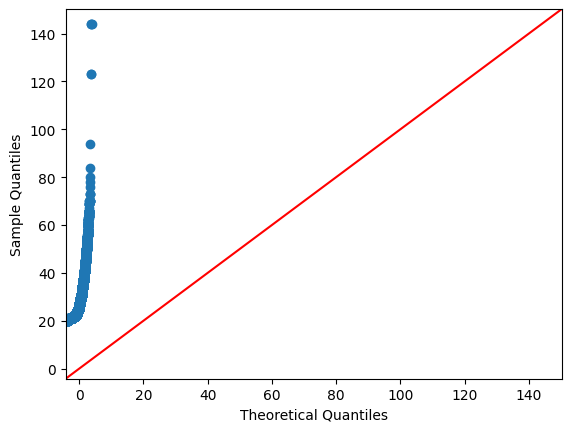

<Figure size 640x480 with 0 Axes>

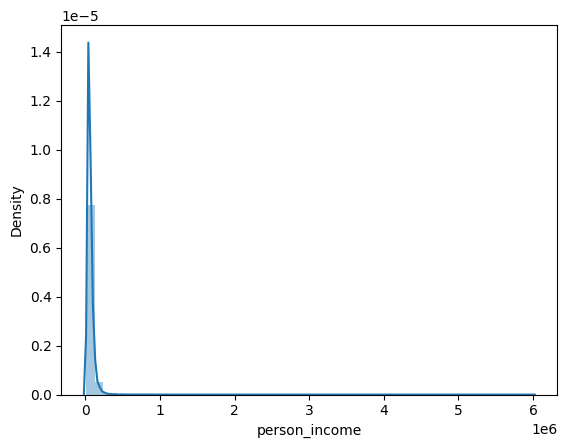

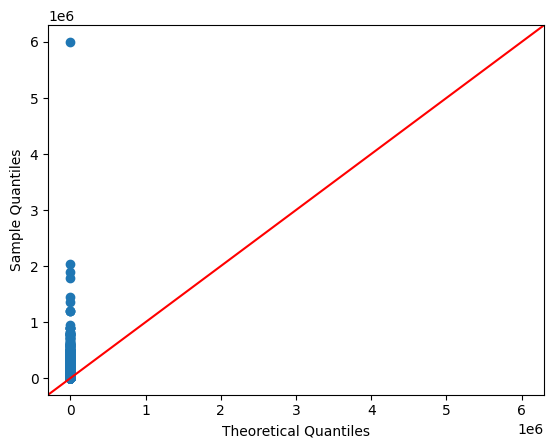

<Figure size 640x480 with 0 Axes>

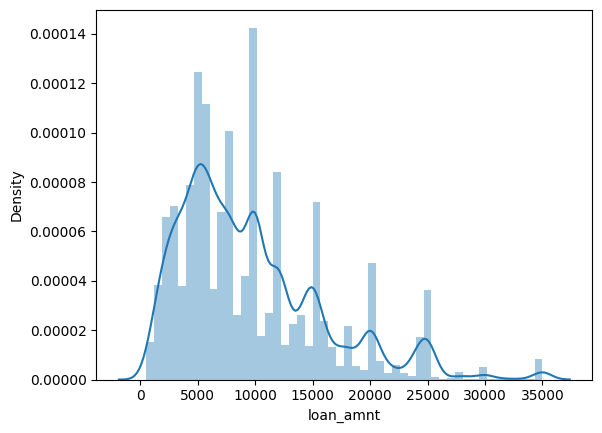

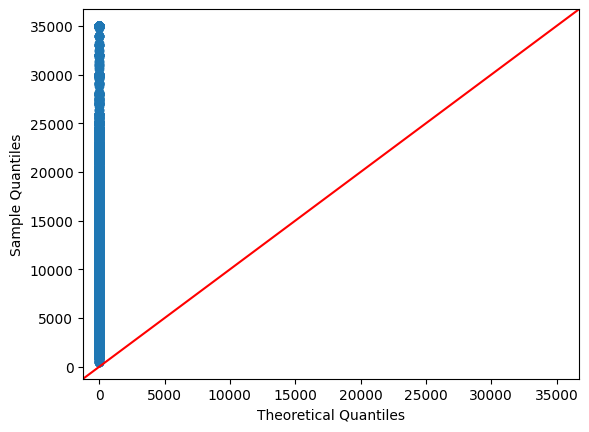

<Figure size 640x480 with 0 Axes>

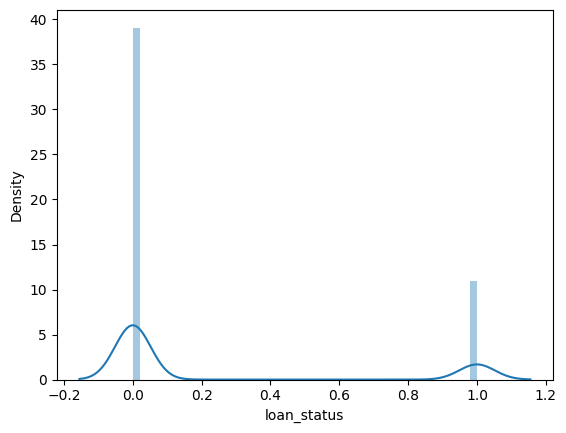

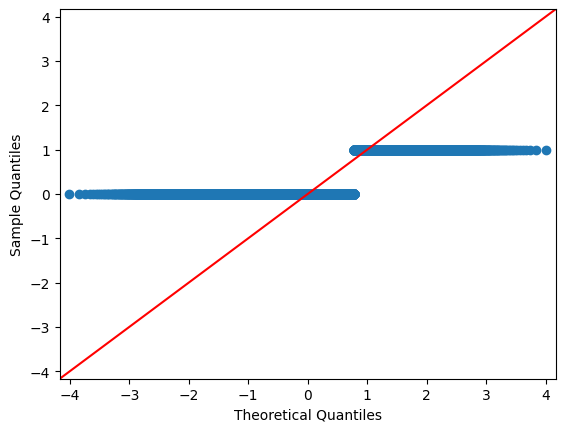

<Figure size 640x480 with 0 Axes>

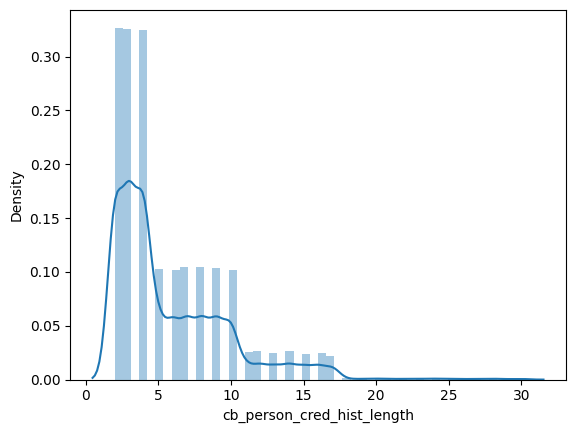

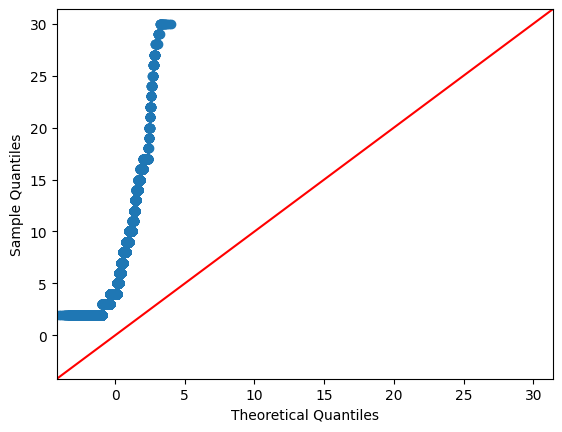

In [14]:
#create distplots of int
for column in df.select_dtypes(include='int64'):
    plt.figure()            
    dist_plot(df,column)
    qq_plot(df,column)
 
    

person_age,

person_income,

loan_amount, 

cb_person_cred_hist_length

....all are somewhat right skewed distributions

<Figure size 640x480 with 0 Axes>

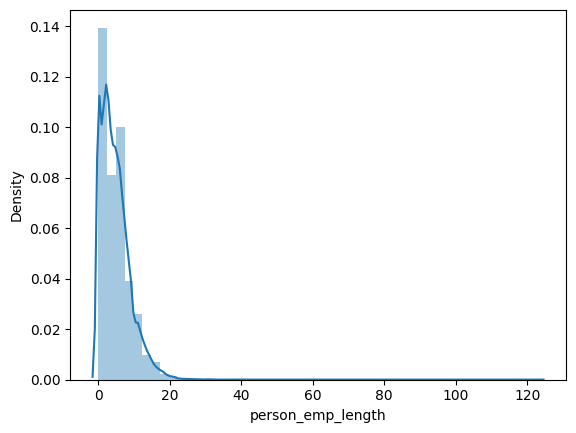

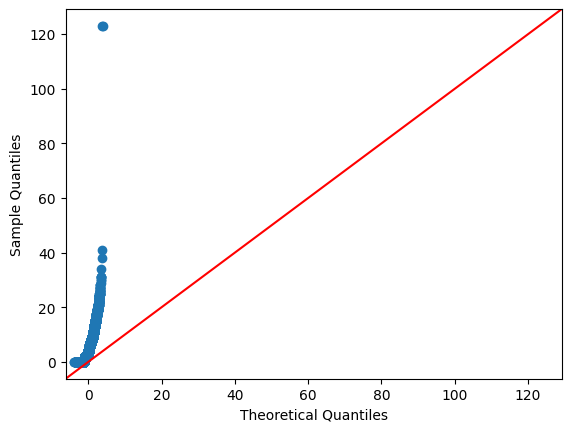

<Figure size 640x480 with 0 Axes>

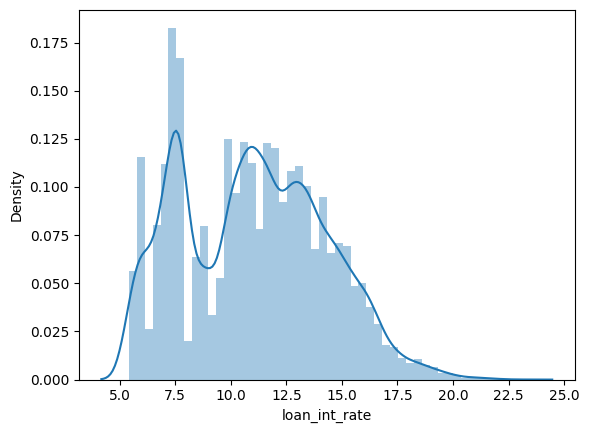

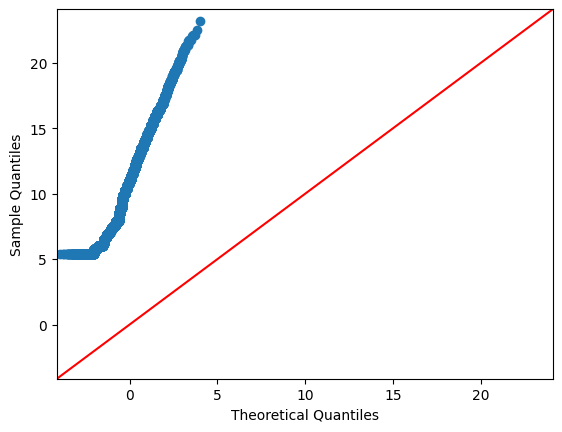

<Figure size 640x480 with 0 Axes>

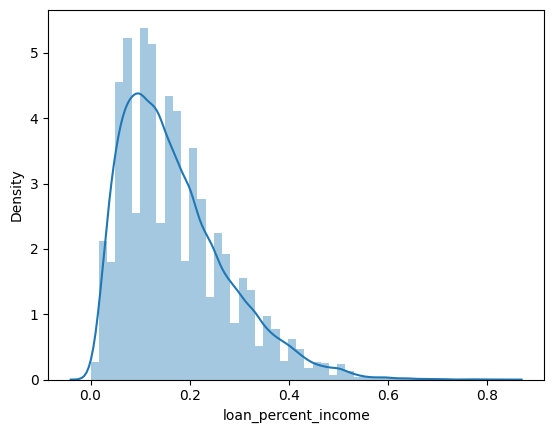

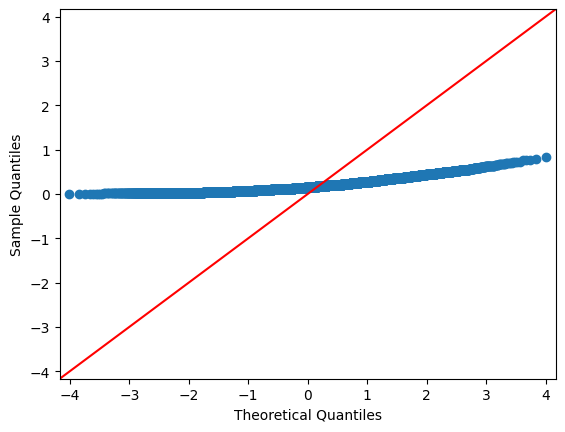

In [15]:
#create distplots of float
for column in df.select_dtypes(include='float'):
    plt.figure()            
    dist_plot(df,column)
    qq_plot(df,column)

person_emp_length, 

loan_percent_income ----------are also right skewed


### Check the values in each feature

In [16]:
for column in df.select_dtypes(include='object'):
    print(df[column].value_counts())
    print("................................................")

person_home_ownership
RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: count, dtype: int64
................................................
loan_intent
EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: count, dtype: int64
................................................
loan_grade
A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: count, dtype: int64
................................................
cb_person_default_on_file
N    26836
Y     5745
Name: count, dtype: int64
................................................


In [17]:
for column in df.select_dtypes(include='int64'):
    print(df[column].value_counts())
    print("................................................")

person_age
23     3889
22     3633
24     3549
25     3037
26     2477
27     2138
28     1854
29     1687
30     1316
21     1229
31     1142
32      964
33      856
34      709
35      620
36      548
37      478
38      373
39      302
40      271
41      241
42      188
43      164
44      141
45      108
46       94
47       94
48       75
50       52
49       49
51       39
52       36
53       30
54       24
55       20
58       19
56       15
57       15
20       15
60       15
65        9
66        9
61        9
70        7
64        7
62        7
59        5
69        5
144       3
73        3
63        3
123       2
78        1
94        1
80        1
84        1
76        1
67        1
Name: count, dtype: int64
................................................
person_income
60000    1046
30000     847
50000     778
40000     658
45000     590
         ... 
54316       1
54480       1
72645       1
72893       1
4888        1
Name: count, Length: 4295, dtype: int64
..........

In [18]:
for column in df.select_dtypes(include='float'):
    print(df[column].value_counts())
    print("................................................")

person_emp_length
0.0      4105
2.0      3849
3.0      3456
5.0      2946
1.0      2915
4.0      2874
6.0      2666
7.0      2196
8.0      1687
9.0      1367
11.0      740
10.0      696
12.0      575
13.0      426
14.0      335
15.0      238
16.0      165
17.0      129
18.0      104
19.0       64
20.0       42
21.0       38
22.0       19
24.0       10
23.0       10
25.0        8
26.0        6
27.0        5
31.0        4
28.0        3
123.0       2
30.0        2
41.0        1
34.0        1
29.0        1
38.0        1
Name: count, dtype: int64
................................................
loan_int_rate
7.51     756
10.99    749
7.49     645
7.88     642
5.42     594
        ... 
21.64      1
20.48      1
17.46      1
21.14      1
20.53      1
Name: count, Length: 348, dtype: int64
................................................
loan_percent_income
0.10    1533
0.13    1482
0.08    1437
0.07    1394
0.11    1381
        ... 
0.62       1
0.76       1
0.83       1
0.72       1
0.78    

Except loan status (which is the target variable) all int and float columns are continuous values

NO catogerical value encoded as 'int'

## 2.3 Checking the correlation between features and target

In [37]:
import pandas as pd

def one_hot_encode(data):
    """
    One-hot encodes object-type columns in the DataFrame.
    """
    return pd.get_dummies(data, drop_first=True,dtype='int64')

def get_corr(data, col):
    """
    Calculates the Spearman correlation for the specified column after
    encoding object-type columns using One-Hot Encoding.
    """
    # One-hot encode object columns
    encoded_data = one_hot_encode(data)
    
    # Compute correlation
    if col in encoded_data.columns:
        cor = encoded_data.corr(method='spearman')[col].sort_values(ascending=False)
        print(cor)
    else:
        print(f"Column '{col}' not found in the dataset after encoding.")


In [33]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [38]:
data = one_hot_encode(df)

In [39]:
data.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,22,59000,123.0,35000,16.02,1,0.59,3,0,0,...,0,1,0,0,0,1,0,0,0,1
1,21,9600,5.0,1000,11.14,0,0.10,2,0,1,...,0,0,0,1,0,0,0,0,0,0
2,25,9600,1.0,5500,12.87,1,0.57,3,0,0,...,1,0,0,0,1,0,0,0,0,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,1,0,0,0,1,0,0,0,0,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,1,0,0,0,1,0,0,0,0,1


In [31]:
get_corr(df,'loan_status')

loan_status                    1.000000
loan_int_rate                  0.320062
loan_grade_D                   0.318998
loan_percent_income            0.316115
person_home_ownership_RENT     0.238430
loan_grade_E                   0.180122
cb_person_default_on_file_Y    0.179141
loan_grade_F                   0.101841
loan_amnt                      0.084032
loan_grade_G                   0.082306
loan_intent_MEDICAL            0.056595
loan_intent_HOMEIMPROVEMENT    0.036607
person_home_ownership_OTHER    0.012543
loan_grade_C                  -0.013031
loan_intent_PERSONAL          -0.021094
cb_person_cred_hist_length    -0.023779
person_age                    -0.033354
loan_intent_EDUCATION         -0.055348
loan_intent_VENTURE           -0.078274
loan_grade_B                  -0.092190
person_emp_length             -0.097558
person_home_ownership_OWN     -0.101960
person_income                 -0.272131
Name: loan_status, dtype: float64


Correlation between features are target are not very high

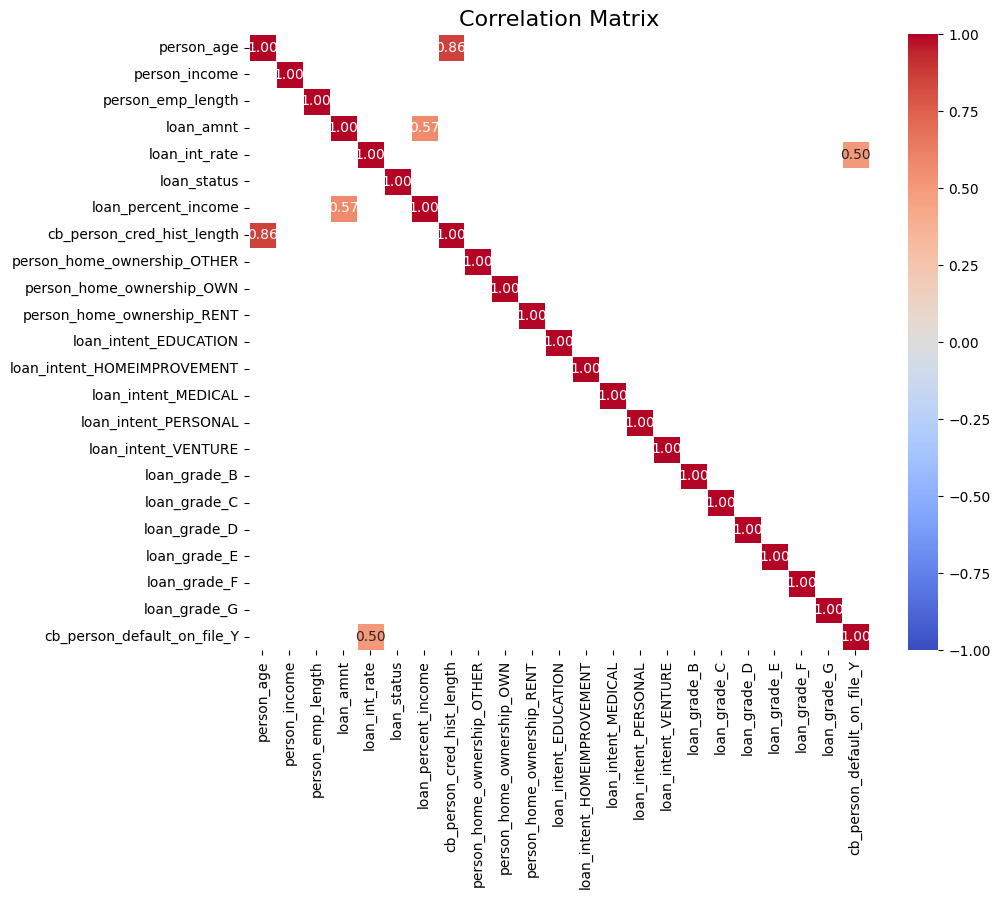

In [43]:
cor = data.corr()
cor = cor[((cor >= .5) | (cor<= -.5))]
plt.figure(figsize=(10, 8))
sns.heatmap(
    cor, 
    annot=True,  # Show correlation values
    fmt=".2f",   # Format for values
    cmap="coolwarm",  # Color scheme
    vmin=-1, vmax=1,  # Scale range
    cbar=True,  # Show color bar
    linewidths=0.5  # Line between cells
)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

loan_amnt -->  loan_percent_income    ----       0.572612


person_age  --> cb_person_cred_hist_length   ---- 0.859133


Very high correlation between person_age  &  cb_person_cred_hist_length 

## 2.4 Checking if Multicollinearity exists in the dataset

In [44]:
#function to check multicolliearity
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [45]:
X = df.select_dtypes(exclude='object').dropna() 
calc_vif(X)

,variables,VIF
0,person_age,28.692238
1,person_income,3.221935
2,person_emp_length,2.457844
3,loan_amnt,7.203001
4,loan_int_rate,11.637547
5,loan_status,1.679846
6,loan_percent_income,8.001678
7,cb_person_cred_hist_length,7.420613


Age has high value for VIF, which indicates that it can be predicted by other independent variables in the dataset.

SO the column 'age' can be dropped ifants to reduce the feature set

# 3. Data Transformation 

### Train Test Split
### Missing Value Imputation, 
### Power Transformation,
### Label Encoding 


In [46]:
target = 'loan_status'
median_list = ['loan_int_rate','person_emp_length']
mean_list = []
log_list = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate','loan_percent_income']
      # 'cb_person_cred_hist_length'
random_seed = 42
test_size =0.3 
label_encode =True
#is_train=True
catogerical_columns = [col for col in df.columns if df[col].dtype=="O"]

In [47]:
catogerical_columns

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [48]:
def Train_Test_Split(data, target):
    X= data.drop(target, axis =1)
    y= data[target]    
       
    X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=test_size, random_state=random_seed)
    return X_train, X_test,y_train,y_test

In [49]:
#Before doing the data transfoamtion lets do the train tets split to avoid data leakage
X_train, X_test,y_train,y_test=Train_Test_Split(df,target)

In [50]:
print(X_train.shape, y_train.shape,X_test.shape,y_test.shape )

(22806, 11) (22806,) (9775, 11) (9775,)


In [51]:
# Imputing nulls and poer transform for numeric columns
num_imputer = SimpleImputer(strategy='median')
power_transformer=   PowerTransformer()
 
# Imputing nulls through the encoding for categorical columns
encoder = OneHotEncoder(handle_unknown="ignore")

# Defining different transformers for numeric and categorical columns
num_transformer = make_pipeline(num_imputer)
pow_transformer = make_pipeline(num_transformer,power_transformer)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, median_list),
                    ('power',pow_transformer,log_list),
                    ('cat', encoder, catogerical_columns)])



# 4. Modelling
# 4.1 Random Forest Classifier

In [52]:
# random forest paraeters tuned using optuna. Code down below
random_forest_parameters = {'n_estimators': 102, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3}


# choosing model
model_name = RandomForestClassifier(n_jobs=-1, random_state=random_seed, **random_forest_parameters)

# giving all values to pipeline
rf_pipe = make_pipeline(preprocessor,model_name)

In [53]:
rf_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['loan_int_rate',
                                                   'person_emp_length']),
                                                 ('power',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median'))])),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['person_age',
                                                   'pe...,
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=3,
                                        min_samples_split=5, n_estimators=102,
                                        n_jobs=-1, random_state=42))])

In [1]:
#export 
path_export = '../Data/randomoforest/saved_models/RF_model.pkl',
pickle.dump(rf_pipe,open(path_export,'wb'))

NameError: name 'pickle' is not defined

In [55]:
# # load model
# with open('RF_model', 'rb') as f:
#     loaded_classifier = pickle.load(f)

# predict
y_true = y_test
y_pred = rf_pipe.predict(X_test)
print('RF_model: recall:', recall_score(y_true, y_pred))
print('RF_model: precision:',precision_score(y_true, y_pred))
print('RF_model: F1 Score:', f1_score(y_true, y_pred))
print('RF_model: accuracy:', accuracy_score(y_true, y_pred))


RF_model: recall: 0.6133209990749307
RF_model: precision: 0.9692982456140351
RF_model: F1 Score: 0.7512747875354108
RF_model: accuracy: 0.9101790281329923


##  4.1.1 Random Forest Classifier tuning using Optuna

In [56]:
# #defining the hyperparatmeter tuning function using optuna
# def rf_objective(trial):
#     _n_estimators = trial.suggest_int("n_estimators", 50, 400)
#     _max_depth = trial.suggest_int("max_depth", 5, 20)
#     _min_samp_split = trial.suggest_int("min_samples_split", 2, 10)
#     _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)
#     #_max_features = trial.suggest_int("max_features", 10, 50)

#     clf = RandomForestClassifier(
#         max_depth=_max_depth,
#         min_samples_split=_min_samp_split,
#         min_samples_leaf=_min_samples_leaf,
#         #max_features=_max_features,
#         n_estimators=_n_estimators,
#         n_jobs=-1,
#         random_state=random_seed
#         )
#     clf.fit(X_train, y_train)
#     return clf.score(X_test, y_test)


# study = optuna.create_study(direction="maximize")
# study.optimize(rf_objective, n_trials=3)

# #choosing the best parameters
# random_forest_parameters=study.best_params

# 4.2 Catboost Classifier

In [57]:
# choosing model
model_name = cat.CatBoostClassifier(iterations=500, verbose=100,eval_metric="Recall")

# giving all values to pipeline
catboost_pipe = make_pipeline(preprocessor,model_name)

catboost_pipe.fit(X_train,y_train)

Learning rate set to 0.073938
0:	learn: 0.5907804	total: 58.5ms	remaining: 29.2s
100:	learn: 0.7197736	total: 1s	remaining: 3.97s
200:	learn: 0.7315002	total: 1.93s	remaining: 2.88s
300:	learn: 0.7450465	total: 2.69s	remaining: 1.78s
400:	learn: 0.7612212	total: 3.46s	remaining: 855ms
499:	learn: 0.7723413	total: 4.32s	remaining: 0us


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['loan_int_rate',
                                                   'person_emp_length']),
                                                 ('power',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median'))])),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7f43d6c62fd0>)])

In [58]:
# # export 
# pickle.dump(catboost_pipe,open('catboost_model.pkl','wb'))

In [59]:
# # load model
# with open('catboost_model.pkl', 'rb') as f:
#     loaded_classifier_catboost = pickle.load(f)

# predict
y_true = y_test
y_pred = catboost_pipe.predict(X_test)
print('Catboost_model: recall:', recall_score(y_true, y_pred))
print('Catboost_model: precision:',precision_score(y_true, y_pred))
print('catboost_model: F1 Score:', f1_score(y_true, y_pred))
print('Catboost_model: accuracy:', accuracy_score(y_true, y_pred))

Catboost_model: recall: 0.7280296022201665
Catboost_model: precision: 0.9692118226600985
catboost_model: F1 Score: 0.8314844162704702
Catboost_model: accuracy: 0.9347314578005115


###  Using catboost recall has increaaed 12%

# 5. Feature Importance

###  5.1 Catboost

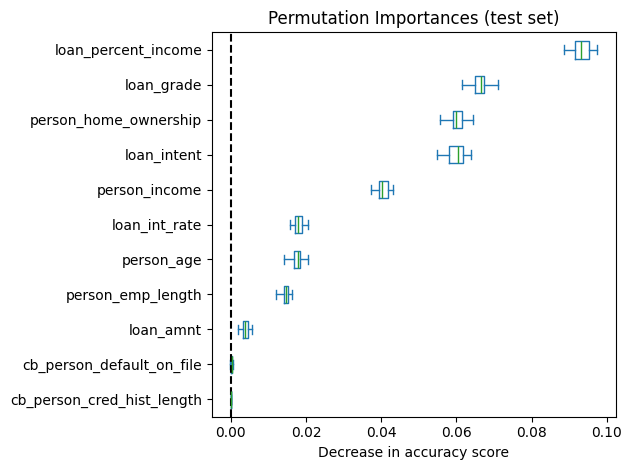

In [60]:
from sklearn.inspection import permutation_importance
result = permutation_importance(catboost_pipe, X_test, y_test,
                           n_repeats=30,
                           random_state=0)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

###  5.2 Random Forest

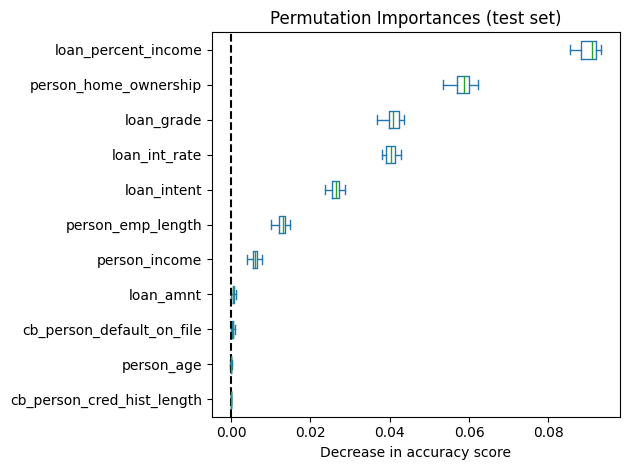

In [61]:
# # load model
# with open('RF_model.pkl', 'rb') as f:
#     loaded_classifier_rf = pickle.load(f)
    
result = permutation_importance(rf_pipe, X_test, y_test,
                           n_repeats=30,
                           random_state=0)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

# 6. Repeat both the pipelines after dropping the two columns with least importance

In [62]:
df_copy.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [63]:
df_copy.drop(columns = ['cb_person_default_on_file','cb_person_cred_hist_length'], axis = 1, inplace =True)

In [64]:
df_copy.columns # after droppig cb_person_credit_hist_length and dcb_person_default_on_file

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income'],
      dtype='object')

In [65]:
# random forest paraeters tuned using optuna. Code down below
random_forest_parameters = {'n_estimators': 102, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3}


# choosing model
model_name = RandomForestClassifier(n_jobs=-1, random_state=random_seed, **random_forest_parameters)

# giving all values to pipeline
rf_pipe_new = make_pipeline(preprocessor,model_name)

In [66]:
rf_pipe_new.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['loan_int_rate',
                                                   'person_emp_length']),
                                                 ('power',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median'))])),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['person_age',
                                                   'pe...,
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=3,
                                        min_samples_split=5, n_estimators=102,
                                        n_jobs=-1, random_state=42))])

In [67]:
# predict
y_true = y_test
y_pred = rf_pipe_new.predict(X_test)
print('RF_model: recall:', recall_score(y_true, y_pred))
print('RF_model: precision:',precision_score(y_true, y_pred))
print('RF_model: F1 Score:', f1_score(y_true, y_pred))
print('RF_model: accuracy:', accuracy_score(y_true, y_pred))

RF_model: recall: 0.6133209990749307
RF_model: precision: 0.9692982456140351
RF_model: F1 Score: 0.7512747875354108
RF_model: accuracy: 0.9101790281329923


In [68]:
# choosing model
model_name = cat.CatBoostClassifier(iterations=500, verbose=100,eval_metric="Recall")

# giving all values to pipeline
catboost_pipe_new = make_pipeline(preprocessor,model_name)

catboost_pipe_new.fit(X_train,y_train)

Learning rate set to 0.073938
0:	learn: 0.5907804	total: 8.45ms	remaining: 4.21s
100:	learn: 0.7197736	total: 796ms	remaining: 3.14s
200:	learn: 0.7315002	total: 1.65s	remaining: 2.46s
300:	learn: 0.7450465	total: 2.72s	remaining: 1.8s
400:	learn: 0.7612212	total: 3.6s	remaining: 888ms
499:	learn: 0.7723413	total: 4.41s	remaining: 0us


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['loan_int_rate',
                                                   'person_emp_length']),
                                                 ('power',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median'))])),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7f43d6d5ebd0>)])

In [69]:
# predict
y_true = y_test
y_pred = catboost_pipe_new.predict(X_test)
print('Catboost_model: recall:', recall_score(y_true, y_pred))
print('Catboost_model: precision:',precision_score(y_true, y_pred))
print('catboost_model: F1 Score:', f1_score(y_true, y_pred))
print('Catboost_model: accuracy:', accuracy_score(y_true, y_pred))

Catboost_model: recall: 0.7280296022201665
Catboost_model: precision: 0.9692118226600985
catboost_model: F1 Score: 0.8314844162704702
Catboost_model: accuracy: 0.9347314578005115


In [ ]:
path_export = '../Data/models/catboost/saved_models/catboost.pkl',
pickle.dump(catboost_pipe_new,open(path_export,'wb'))

## Conclusion 


Recall , Precision, F1 Score and accuracy of catboost algorthm is better comapred to random Forest.

So catboost model is better model for this data set among random forest and catboost
